In [68]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [70]:
def visualize_loss_accuracy(num_epochs, list_losses, list_accuracies):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(num_epochs)), list_losses, label='Loss', color='blue')
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(list(range(num_epochs)), list_accuracies, label='Accuracy', color='orange')
    plt.title('Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy, %')
    plt.legend()
    
    plt.show()

In [71]:
def visual_heatmap(loader, predicted_labels):
    orig_test_labels = []
    for images, labels in loader:
        orig_test_labels.extend(labels)    
        
    predicted_labels_list = [predicted_labels[i].item() for i in range(len(predicted_labels))]
    
    cm = confusion_matrix(orig_test_labels, predicted_labels_list)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(orig_test_labels))), yticklabels=np.arange(len(np.unique(orig_test_labels))))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted classes')
    plt.ylabel('Original classes')
    plt.show()

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [73]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Original classes

In [74]:
def imshow_train(images, labels, num_images=5):
    plt.figure(figsize=(15, 6))
    
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'Класс: {labels[i]}')
        plt.axis('off')
        
    plt.show()

In [75]:
def create_data_loader(dataset):
    return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Train data


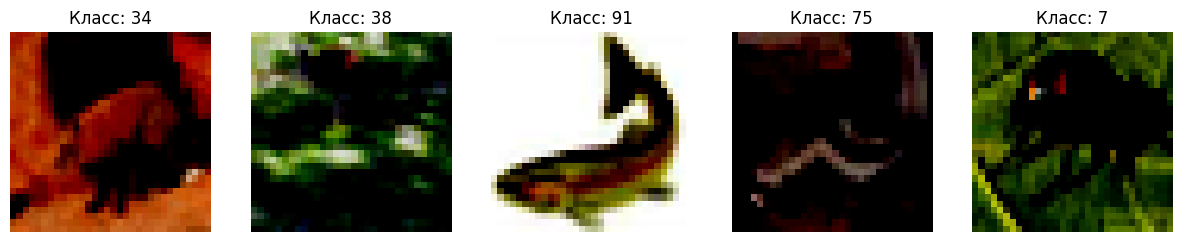

Test data


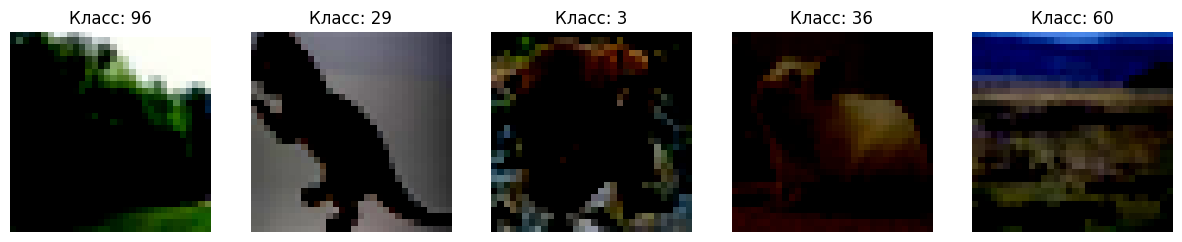

In [76]:
trainloader_orig = create_data_loader(trainset)
testloader_orig = create_data_loader(testset)

print('Train data')
train_images, train_labels = next(iter(trainloader_orig))
train_images, train_labels = train_images.to(device), train_labels.to(device)
imshow_train(train_images.cpu().numpy(), train_labels.cpu().numpy())

print('Test data')
test_images, test_labels = next(iter(testloader_orig))
test_images, test_labels = test_images.to(device), test_labels.to(device)
imshow_train(test_images.cpu().numpy(), test_labels.cpu().numpy())

# Change classes

In [77]:
bicycle_class = 19
motorcycle_class = 22
background_classes = [i for i in range(100) if i not in [bicycle_class, motorcycle_class]]

def transform_labels(y):
    if y == bicycle_class:
        return 0
    elif y == motorcycle_class:
        return 1
    else:
        return 2

In [78]:
trainset.targets = [transform_labels(y) for y in trainset.targets if y in [bicycle_class, motorcycle_class] + background_classes]
trainset.data = trainset.data[[i for i in range(len(trainset.targets)) if trainset.targets[i] in [0, 1, 2]]]

testset.targets = [transform_labels(y) for y in testset.targets if y in [bicycle_class, motorcycle_class] + background_classes]
testset.data = testset.data[[i for i in range(len(testset.targets)) if testset.targets[i] in [0, 1, 2]]]

Train data


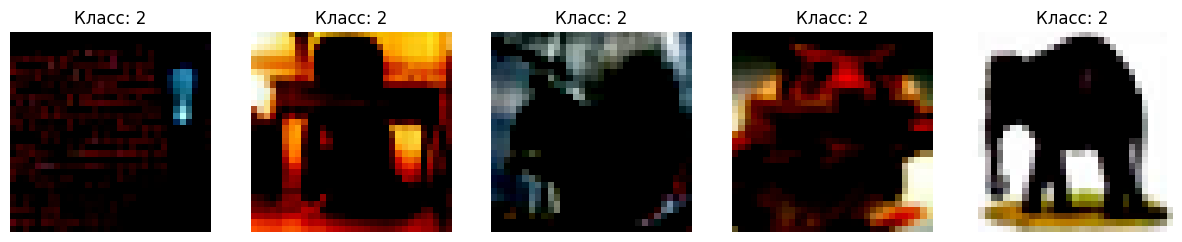

Test data


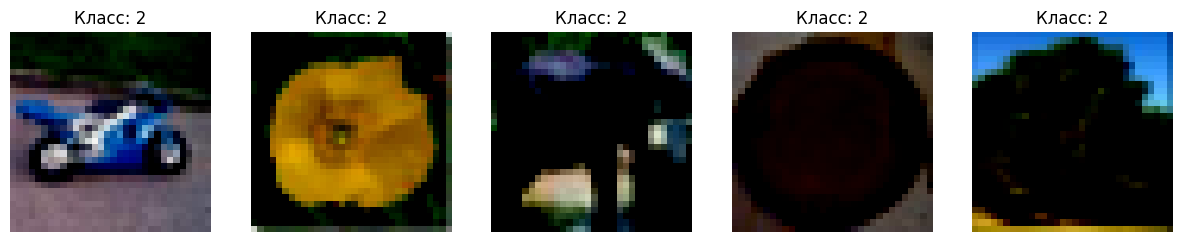

In [79]:
trainloader = create_data_loader(trainset)
testloader = create_data_loader(testset)

print('Train data')
train_images, train_labels = next(iter(trainloader))
train_images, train_labels = train_images.to(device), train_labels.to(device)
imshow_train(train_images.cpu().numpy(), train_labels.cpu().numpy())

print('Test data')
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
imshow_train(test_images.cpu().numpy(), test_labels.cpu().numpy())

# Training and validation loops

In [80]:
def train(num_epochs, trainloader, model, optimizer, criterion):
    train_losses = []
    train_accuracies = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        epoch_loss = running_loss/len(trainloader)
        epoch_accuracy = correct/total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
    
        print(f'Epochs {epoch + 1}/{num_epochs}, Loss : {epoch_loss}, Accuracy : {epoch_accuracy}')

    return train_losses, train_accuracies

In [81]:
def validate_model(model, dataloader, num_classes, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    recall = {cls: 0 for cls in range(num_classes)}
    count_per_class = {cls: 0 for cls in range(num_classes)}

    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            predicted_labels.extend(predicted)

            for cls in range(num_classes):
                true_positive = ((predicted == cls) & (labels == cls)).sum().item()
                false_negative = ((predicted != cls) & (labels == cls)).sum().item()
                
                recall[cls] += true_positive
                count_per_class[cls] += (true_positive + false_negative)

    accuracy = total_correct / total_samples

    for cls in range(num_classes):
        if count_per_class[cls] > 0:
            recall[cls] = recall[cls] / count_per_class[cls]
        else:
            recall[cls] = 0.0

    return accuracy, recall, predicted_labels

# Experimets

In [82]:
exp_results = pd.DataFrame(columns=['accuracy', 'recall'])

## Exp01

In [83]:
model_res18 = models.resnet18(pretrained=True)

model_res18.fc = nn.Linear(model_res18.fc.in_features, 3)
model_res18 = model_18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
num_epochs = 10

model = model_res18
optimizer = optim.Adam(model_res18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = train(num_epochs, trainloader, model, optimizer, criterion)

 10%|█         | 1/10 [00:35<05:15, 35.11s/it]

Epochs 1/10, Loss : 0.08584544587734687, Accuracy : 0.97998


 20%|██        | 2/10 [01:09<04:39, 34.98s/it]

Epochs 2/10, Loss : 0.07917601486306902, Accuracy : 0.9802


 30%|███       | 3/10 [01:44<04:04, 34.92s/it]

Epochs 3/10, Loss : 0.0781561764435615, Accuracy : 0.9803


 40%|████      | 4/10 [02:19<03:28, 34.77s/it]

Epochs 4/10, Loss : 0.07879321531333644, Accuracy : 0.9808


 50%|█████     | 5/10 [02:54<02:53, 34.74s/it]

Epochs 5/10, Loss : 0.07102253472328815, Accuracy : 0.98176


 60%|██████    | 6/10 [03:28<02:18, 34.71s/it]

Epochs 6/10, Loss : 0.06257266257409905, Accuracy : 0.98296


 70%|███████   | 7/10 [04:03<01:44, 34.69s/it]

Epochs 7/10, Loss : 0.05569513602109575, Accuracy : 0.98456


 80%|████████  | 8/10 [04:38<01:09, 34.68s/it]

Epochs 8/10, Loss : 0.047806476011350324, Accuracy : 0.986


 90%|█████████ | 9/10 [05:12<00:34, 34.65s/it]

Epochs 9/10, Loss : 0.040779821771767255, Accuracy : 0.9878


100%|██████████| 10/10 [05:47<00:00, 34.73s/it]

Epochs 10/10, Loss : 0.033659107652486864, Accuracy : 0.98966


In [85]:
num_classes = 3
accuracy, recall, predicted_labels = validate_model(model_res18, testloader, num_classes, device)

print(f'Accuracy on test set: {val_acc}')
print(f'Recall for all classes on test set: {recall}')

exp_results.loc['model_res18'] = {'accuracy' : val_acc, 'recall' : np.mean(list(recall.values()))}
exp_results

Accuracy on test set: 0.938
Recall for all classes on test set: {0: 0.16, 1: 0.37, 2: 0.9954081632653061}


,accuracy,recall
model_res18,0.938,0.508469


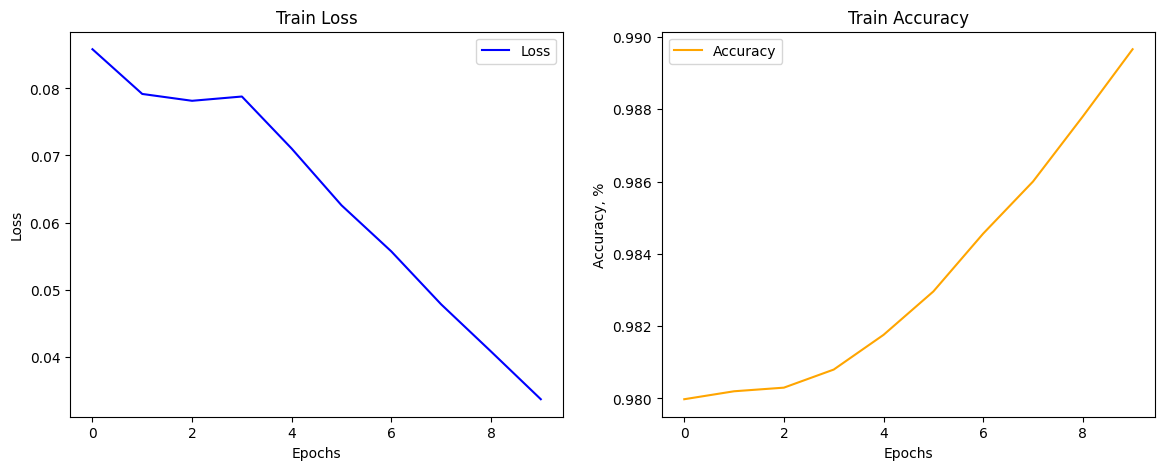

In [86]:
visualize_loss_accuracy(num_epochs, train_losses, train_accuracies)

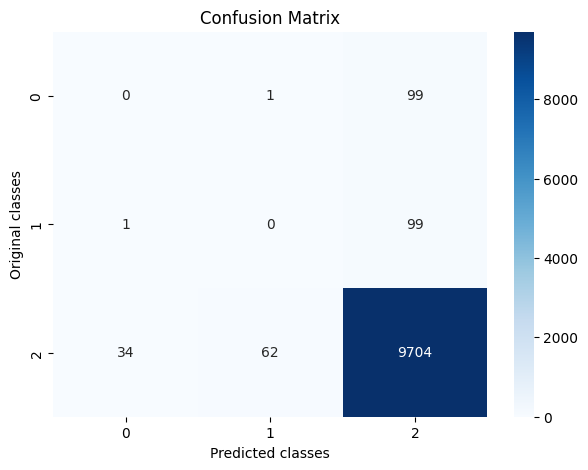

In [87]:
visual_heatmap(testloader, predicted_labels)

# Дизбланс классов

In [88]:
def count_class_elemens(loader):
    all_labels = [] 
    for images, labels in loader:
        all_labels.extend([label.item() for label in labels])
    
    dict_labels = {0 : 0, 1 : 0, 2 : 0}
    for el in all_labels:
        dict_labels[el] += 1
    
    return dict_labels

In [89]:
print(f'Train : {count_class_elemens(trainloader)}')
print(f'Test : {count_class_elemens(testloader)}')

Train : {0: 500, 1: 500, 2: 49000}
Test : {0: 100, 1: 100, 2: 9800}


Так как в датасете CIFAR100 в train выборке представлены 100 классов по 500 элемнтов на каждый, а в test выборке 100 классов по 100 элементов, то при выделении 98 классов в один будет наблюдаться большой дисбаланс классов. Для того, чтобы модель часто не предсказывала класс "background", необходимо сделать аугментацию данных на малозначительный класс, также можно поменять функцию потерь, для того чтобы она старалась минимизировать FP сценариев.

## Exp02

In [90]:
model_res18 = models.resnet18(pretrained=True)

model_res18.fc = nn.Linear(model_res18.fc.in_features, 3)
model_res18 = model_18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [91]:
num_classes = 3
class_counts = list(dict_train_labels.values())
total_count = sum(class_counts)

class_weights = [total_count / (num_classes * count) for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

In [92]:
num_epochs = 10

model = model_res18
optimizer = optim.Adam(model_res18.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, train_accuracies = train(num_epochs, trainloader, model, optimizer, criterion)

 10%|█         | 1/10 [00:35<05:18, 35.44s/it]

Epochs 1/10, Loss : 0.2749656048442549, Accuracy : 0.94608


 20%|██        | 2/10 [01:10<04:42, 35.25s/it]

Epochs 2/10, Loss : 0.14481147302279485, Accuracy : 0.96502


 30%|███       | 3/10 [01:45<04:05, 35.11s/it]

Epochs 3/10, Loss : 0.21433535240166324, Accuracy : 0.951


 40%|████      | 4/10 [02:20<03:30, 35.07s/it]

Epochs 4/10, Loss : 0.15879850712569368, Accuracy : 0.95816


 50%|█████     | 5/10 [02:55<02:55, 35.04s/it]

Epochs 5/10, Loss : 0.14684527081849144, Accuracy : 0.96616


 60%|██████    | 6/10 [03:30<02:20, 35.03s/it]

Epochs 6/10, Loss : 0.3142601802961672, Accuracy : 0.92712


 70%|███████   | 7/10 [04:05<01:45, 35.10s/it]

Epochs 7/10, Loss : 0.2763076947307213, Accuracy : 0.92852


 80%|████████  | 8/10 [04:40<01:10, 35.06s/it]

Epochs 8/10, Loss : 0.13246992142377653, Accuracy : 0.96486


 90%|█████████ | 9/10 [05:15<00:35, 35.01s/it]

Epochs 9/10, Loss : 0.08910844375694293, Accuracy : 0.97164


100%|██████████| 10/10 [05:50<00:00, 35.07s/it]

Epochs 10/10, Loss : 0.12109435223697959, Accuracy : 0.96968


In [93]:
num_classes = 3
accuracy, recall, predicted_labels = validate_model(model_res18, testloader, num_classes, device)

print(f'Accuracy on test set: {val_acc}')
print(f'Recall for all classes on test set: {recall}')

exp_results.loc['model_res18_weights'] = {'accuracy' : val_acc, 'recall' : np.mean(list(recall.values()))}
exp_results

Accuracy on test set: 0.938
Recall for all classes on test set: {0: 0.46, 1: 0.42, 2: 0.9653061224489796}


,accuracy,recall
model_res18,0.938,0.508469
model_res18_weights,0.938,0.615102


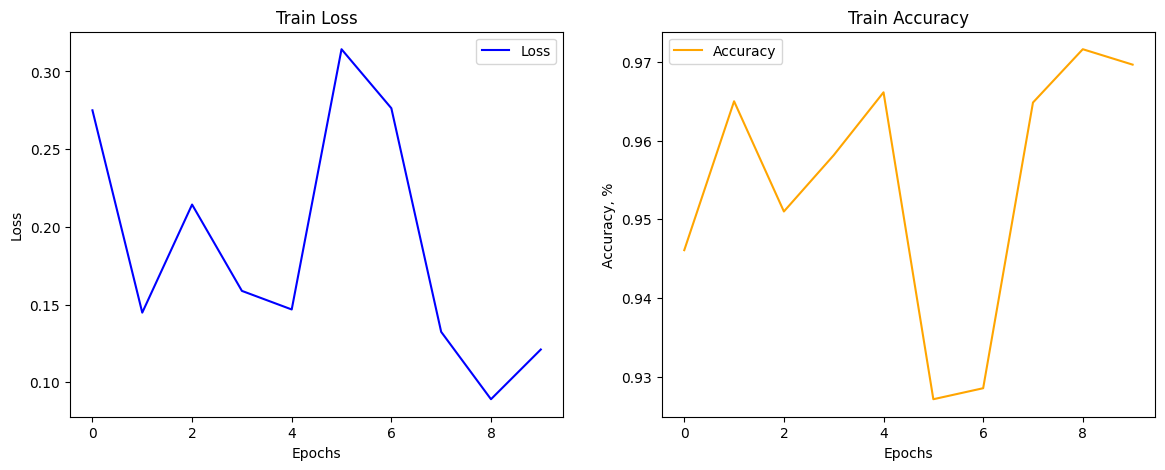

In [94]:
visualize_loss_accuracy(num_epochs, train_losses, train_accuracies)

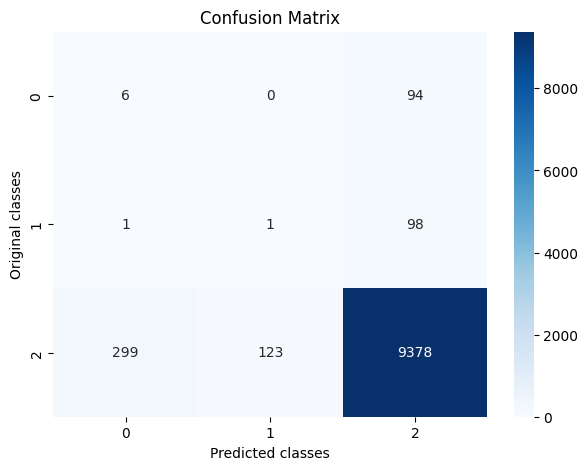

In [95]:
visual_heatmap(testloader, predicted_labels)

Результат точности на тестовой выборке снизился, однако стоит отметить, что модель значительно меньше раз предсказывала класс background.

## Exp03

In [96]:
model_res50 = models.resnet50(pretrained=True)

model_res50.fc = nn.Linear(model_res50.fc.in_features, 3)
model_res50 = model_res50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
num_epochs = 10

model = model_res50
optimizer = optim.Adam(model_res50.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, train_accuracies = train(num_epochs, trainloader, model, optimizer, criterion)

 10%|█         | 1/10 [01:05<09:48, 65.38s/it]

Epochs 1/10, Loss : 1.0456716562177384, Accuracy : 0.88778


 20%|██        | 2/10 [02:10<08:41, 65.20s/it]

Epochs 2/10, Loss : 0.9960229381518492, Accuracy : 0.88858


 30%|███       | 3/10 [03:15<07:37, 65.32s/it]

Epochs 3/10, Loss : 0.8104170923784461, Accuracy : 0.87148


 40%|████      | 4/10 [04:21<06:31, 65.26s/it]

Epochs 4/10, Loss : 0.8097858454982059, Accuracy : 0.8661


 50%|█████     | 5/10 [05:26<05:26, 65.28s/it]

Epochs 5/10, Loss : 0.7966354615504896, Accuracy : 0.89412


 60%|██████    | 6/10 [06:31<04:20, 65.16s/it]

Epochs 6/10, Loss : 0.7581019936628778, Accuracy : 0.87526


 70%|███████   | 7/10 [07:36<03:15, 65.24s/it]

Epochs 7/10, Loss : 0.6352538611031997, Accuracy : 0.86692


 80%|████████  | 8/10 [08:41<02:10, 65.14s/it]

Epochs 8/10, Loss : 0.8156270714415927, Accuracy : 0.8849


 90%|█████████ | 9/10 [09:46<01:05, 65.09s/it]

Epochs 9/10, Loss : 0.8691690931870094, Accuracy : 0.87288


100%|██████████| 10/10 [10:51<00:00, 65.18s/it]

Epochs 10/10, Loss : 0.8264572818692647, Accuracy : 0.86532


In [98]:
num_classes = 3
accuracy, recall, predicted_labels = validate_model(model_res50, testloader, num_classes, device)

print(f'Accuracy on test set: {val_acc}')
print(f'Recall for all classes on test set: {recall}')

exp_results.loc['model_res50'] = {'accuracy' : val_acc, 'recall' : np.mean(list(recall.values()))}
exp_results

Accuracy on test set: 0.938
Recall for all classes on test set: {0: 0.25, 1: 0.39, 2: 0.8236734693877551}


,accuracy,recall
model_res18,0.938,0.508469
model_res18_weights,0.938,0.487891


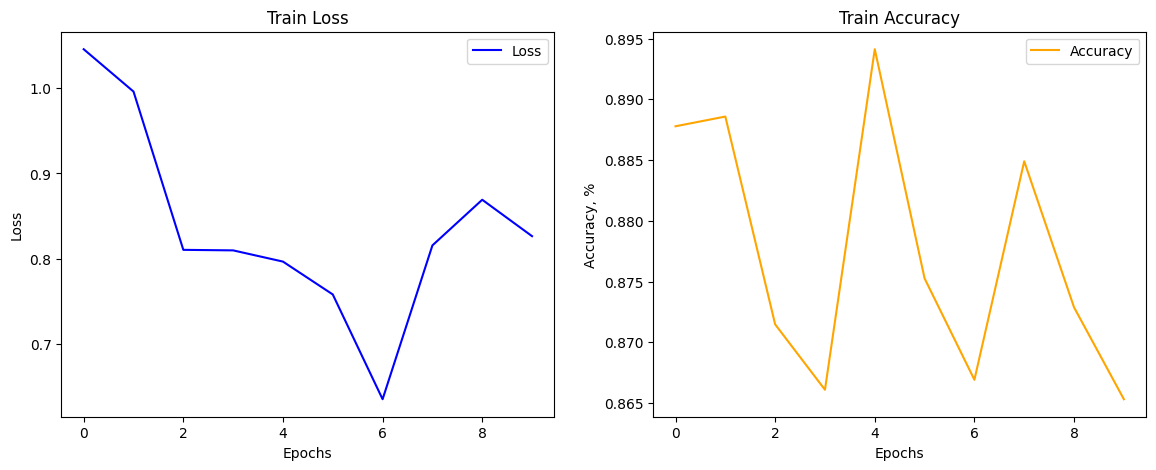

In [99]:
visualize_loss_accuracy(num_epochs, train_losses, train_accuracies)

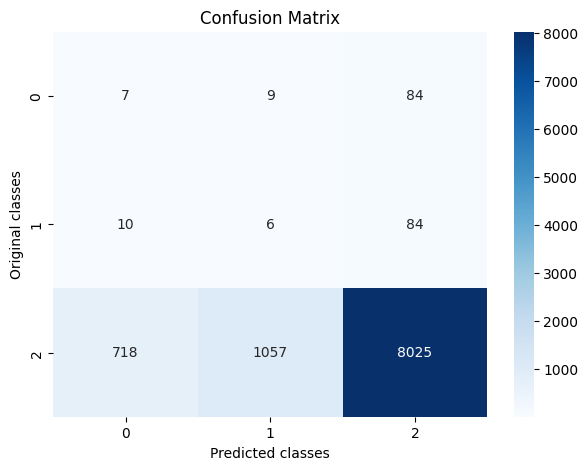

In [100]:
visual_heatmap(testloader, predicted_labels)

# Grayscale